In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===========================================================
 Two Moons — PyTorch MLP Trainer (Interactive GUI) 
 Version 1 – PyTorch-based
===========================================================

An interactive PyTorch-powered visualization and trainer for 
the classic “Two Moons” dataset.This version leverages the 
full PyTorch framework — including tensor operations,
automatic differentiation, and optimizers — to train 
multilayer perceptrons (MLPs) in real time. Users can 
freely adjust architecture depth, learning rate, and
data noise to observe how these factors influence 
convergence and decision boundaries.

-----------------------------------------------------------
 Features
-----------------------------------------------------------
 • Real-time visualization of model decision boundaries.
 • Adjustable noise, learning rate, and weight decay.
 • Configurable 3-layer MLP architecture.
 • On-the-fly data regeneration and LR decay.
 • Interactive training with Start, Pause, Step, and Reset.

-----------------------------------------------------------
 Author:  Burak Demirel
 Title:   MRI Clinical Scientist
 Company: Philips Healthcare
 Contact: burak.demirel@philips.com
-----------------------------------------------------------

Run with:
    python two_moons_pytorch_gui.py

Requirements:
    - numpy
    - matplotlib
    - tkinter (built-in)
    - torch

Tested on:
    Python 3.9+, Windows/Linux/macOS

-----------------------------------------------------------
"""

import numpy as np
import matplotlib
matplotlib.use("TkAgg")  # Use TkAgg backend for Tkinter embedding
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import ttk

import torch
import torch.nn as nn
import torch.optim as optim

# -------------------- Data utils --------------------

def make_moons(n=1200, noise=0.35, seed=42):
    rng = np.random.default_rng(seed)
    n2 = n // 2
    t = np.linspace(0, np.pi, n2)
    x1 = np.c_[np.cos(t), np.sin(t)]
    x2 = np.c_[1 - np.cos(t), 1 - np.sin(t)] + np.array([0.0, -0.5])
    X = np.vstack([x1, x2])
    X += noise * rng.standard_normal(X.shape)
    y = np.hstack([np.zeros(n2), np.ones(n2)])
    return X.astype(np.float32), y.astype(np.float32)

def standardize_np(X):
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + 1e-8
    return (X - mu) / sd, mu.squeeze(0), sd.squeeze(0)

# -------------------- Model (PyTorch) --------------------

class MLP(nn.Module):
    def __init__(self, input_dim=2, h1=128, h2=128, h3=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(inplace=True),
            nn.Linear(h1, h2),
            nn.ReLU(inplace=True),
            nn.Linear(h2, h3),
            nn.ReLU(inplace=True),
            nn.Linear(h3, 1)  # logits (no sigmoid; use BCEWithLogitsLoss)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)  # (N,)

# -------------------- GUI App --------------------

class TrainerApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Two Moons — PyTorch MLP Trainer")
        self.running = False
        self.epoch = 0

        # Tk variables
        self.epochs_per_update = tk.IntVar(value=5)
        self.noise = tk.DoubleVar(value=0.35)
        self.lr = tk.DoubleVar(value=0.01)
        self.weight_decay = tk.DoubleVar(value=1e-4)
        self.hidden1 = tk.IntVar(value=128)
        self.hidden2 = tk.IntVar(value=128)
        self.hidden3 = tk.IntVar(value=64)
        self.seed = tk.IntVar(value=42)

        # Layout
        self.control_frame = ttk.Frame(self.root, padding=8)
        self.control_frame.grid(row=0, column=0, sticky="ns")
        self.plot_frame = ttk.Frame(self.root, padding=8)
        self.plot_frame.grid(row=0, column=1, sticky="nsew")
        self.root.columnconfigure(1, weight=1)
        self.root.rowconfigure(0, weight=1)

        self._build_controls()
        self._build_plots()

        # Prepare data/model
        self._reset_all(init_only=True)

    # ----- UI builders -----
    def _build_controls(self):
        # Buttons
        btns = ttk.Frame(self.control_frame)
        btns.grid(row=0, column=0, sticky="ew", pady=(0,8))
        self.start_btn = ttk.Button(btns, text="Start", command=self.start)
        self.start_btn.grid(row=0, column=0, padx=2)
        self.pause_btn = ttk.Button(btns, text="Pause", command=self.pause, state="disabled")
        self.pause_btn.grid(row=0, column=1, padx=2)
        self.step_btn = ttk.Button(btns, text="Step Once", command=lambda: self.step_train(1))
        self.step_btn.grid(row=0, column=2, padx=2)
        self.reset_btn = ttk.Button(btns, text="Reset", command=self.reset_and_rebuild)
        self.reset_btn.grid(row=0, column=3, padx=2)

        # Epochs per update
        epf = ttk.Frame(self.control_frame)
        epf.grid(row=1, column=0, sticky="ew", pady=4)
        ttk.Label(epf, text="Epochs/update:").grid(row=0, column=0, sticky="w")
        ttk.Combobox(epf, textvariable=self.epochs_per_update, values=[1,2,5,10,20,50,100],
                     width=6, state="readonly").grid(row=0, column=1, padx=4)

        # Hyperparameters
        hp = ttk.LabelFrame(self.control_frame, text="Hyperparameters", padding=6)
        hp.grid(row=2, column=0, sticky="ew", pady=6)
        self._add_labeled_entry(hp, "Learning rate:", self.lr, row=0, width=10)
        self._add_labeled_entry(hp, "Weight decay:", self.weight_decay, row=1, width=10)

        # Architecture
        arch = ttk.LabelFrame(self.control_frame, text="Architecture", padding=6)
        arch.grid(row=3, column=0, sticky="ew", pady=6)
        self._add_labeled_entry(arch, "Hidden 1:", self.hidden1, row=0, width=6)
        self._add_labeled_entry(arch, "Hidden 2:", self.hidden2, row=1, width=6)
        self._add_labeled_entry(arch, "Hidden 3:", self.hidden3, row=2, width=6)

        # Data params
        dataf = ttk.LabelFrame(self.control_frame, text="Data", padding=6)
        dataf.grid(row=4, column=0, sticky="ew", pady=6)
        ttk.Label(dataf, text="Noise:").grid(row=0, column=0, sticky="w")
        ttk.Scale(dataf, from_=0.0, to=0.6, orient="horizontal",
                  variable=self.noise, command=lambda e: None).grid(row=0, column=1, sticky="ew", padx=4)
        dataf.columnconfigure(1, weight=1)
        self._add_labeled_entry(dataf, "Seed:", self.seed, row=1, width=8)
        ttk.Button(dataf, text="Regenerate Data", command=self.regen_data).grid(row=2, column=0, columnspan=2, pady=4, sticky="ew")

        # Status
        self.status = tk.StringVar(value="Ready.")
        ttk.Label(self.control_frame, textvariable=self.status, wraplength=220, justify="left").grid(row=5, column=0, sticky="ew", pady=6)

    def _add_labeled_entry(self, parent, label, var, row, width=8):
        ttk.Label(parent, text=label).grid(row=row, column=0, sticky="w")
        e = ttk.Entry(parent, textvariable=var, width=width)
        e.grid(row=row, column=1, sticky="w", padx=4)

    def _build_plots(self):
        self.fig = plt.Figure(figsize=(7.5, 6.5), dpi=100)
        self.ax = self.fig.add_subplot(121)
        self.ax.set_title("Two Moons & Decision Boundary")
        self.ax.set_xlabel("X1"); self.ax.set_ylabel("X2")

        self.ax2 = self.fig.add_subplot(122)
        self.ax2.set_title("Loss Curve")
        self.ax2.set_xlabel("Epoch"); self.ax2.set_ylabel("Binary Cross-Entropy")

        self.canvas = FigureCanvasTkAgg(self.fig, master=self.plot_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(fill="both", expand=True)

    # ----- Training mechanics -----
    def _reset_all(self, init_only=False):
        # Data
        X_np, y_np = make_moons(n=1200, noise=float(self.noise.get()), seed=int(self.seed.get()))
        Xs_np, self.mu_np, self.sd_np = standardize_np(X_np)

        self.X = torch.from_numpy(X_np)       # for plotting only
        self.Xs = torch.from_numpy(Xs_np)     # training input (standardized)
        self.y = torch.from_numpy(y_np)       # labels (0/1), shape (N,)

        # Model
        self.model = MLP(
            input_dim=2,
            h1=int(self.hidden1.get()),
            h2=int(self.hidden2.get()),
            h3=int(self.hidden3.get()),
        )

        # Loss + Optimizer (bias/extras no weight decay)
        lr = float(self.lr.get())
        wd = float(self.weight_decay.get())
        decay, no_decay = [], []
        for name, p in self.model.named_parameters():
            if p.requires_grad:
                if name.endswith(".bias"):
                    no_decay.append(p)
                else:
                    decay.append(p)
        param_groups = [
            {"params": decay, "weight_decay": wd},
            {"params": no_decay, "weight_decay": 0.0},
        ]
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(param_groups, lr=lr, betas=(0.9, 0.999), eps=1e-8)

        self.losses = []
        self.epoch = 0

        # Decision grid (precompute once)
        x_min, x_max = self.X[:, 0].min().item() - 0.6, self.X[:, 0].max().item() + 0.6
        y_min, y_max = self.X[:, 1].min().item() - 0.6, self.X[:, 1].max().item() + 0.6
        self.xx, self.yy = np.meshgrid(np.linspace(x_min, x_max, 220),
                                       np.linspace(y_min, y_max, 220))
        self.grid_np = np.c_[self.xx.ravel(), self.yy.ravel()].astype(np.float32)

        # Initial draw
        self._draw_plots()
        if not init_only:
            self.status.set("Reset complete.")

    def _lr_decay_if_needed(self):
        # Decay LR every 500 epochs by 0.7 (like the original)
        if self.epoch > 0 and self.epoch % 500 == 0:
            for g in self.optimizer.param_groups:
                g["lr"] *= 0.7

    def regen_data(self):
        self.pause()
        self._reset_all(init_only=False)

    def reset_and_rebuild(self):
        self.pause()
        self._reset_all(init_only=False)

    def start(self):
        if self.running:
            return
        self.running = True
        self.start_btn.config(state="disabled")
        self.pause_btn.config(state="normal")
        self.status.set("Training...")
        self._schedule_step()

    def pause(self):
        if not self.running:
            return
        self.running = False
        self.start_btn.config(state="normal")
        self.pause_btn.config(state="disabled")
        self.status.set("Paused.")

    def _schedule_step(self):
        if self.running:
            self.step_train(int(self.epochs_per_update.get()))
            self.root.after(50, self._schedule_step)

    def step_train(self, k):
        self.model.train()
        Xs = self.Xs
        y = self.y
        for _ in range(int(k)):
            logits = self.model(Xs)                  # (N,)
            loss = self.criterion(logits, y)         # scalar
            self.optimizer.zero_grad(set_to_none=True)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
            self.epoch += 1
            self._lr_decay_if_needed()
        self._draw_plots()

    @torch.no_grad()
    def _draw_plots(self):
        # Decision boundary
        self.ax.clear()
        mask = self.y.numpy() > 0.5
        self.ax.scatter(self.X.numpy()[~mask, 0], self.X.numpy()[~mask, 1], alpha=0.7, label="A (0)", s=12)
        self.ax.scatter(self.X.numpy()[mask, 0],  self.X.numpy()[mask, 1],  alpha=0.7, label="B (1)", s=12)

        # Standardize grid using stored mu/sd (numpy) then torch forward
        grid_s_np = (self.grid_np - self.mu_np) / self.sd_np
        grid_s = torch.from_numpy(grid_s_np)
        self.model.eval()
        logits_grid = self.model(grid_s)            # (G,)
        probs_grid = torch.sigmoid(logits_grid).cpu().numpy().reshape(self.xx.shape)
        cs = self.ax.contour(self.xx, self.yy, probs_grid, levels=[0.5])
        self.ax.clabel(cs, inline=True, fontsize=8)

        # Train accuracy
        logits_train = self.model(self.Xs)
        probs_train = torch.sigmoid(logits_train)
        preds = (probs_train >= 0.5).float()
        acc = (preds.eq(self.y)).float().mean().item()

        # Title & labels
        cur_lr = self.optimizer.param_groups[0]["lr"]
        title = f"Two Moons | {self.model.net[0].out_features}-{self.model.net[2].out_features}-{self.model.net[4].out_features} ReLU MLP + Sigmoid/BCE\n"
        title += f"Epoch: {self.epoch}  Acc: {acc*100:.1f}%  LR: {cur_lr:.5f}  Noise: {float(self.noise.get()):.2f}"
        self.ax.set_title(title)
        self.ax.set_xlabel("X1"); self.ax.set_ylabel("X2")
        self.ax.legend(loc="lower left")

        # Loss curve
        self.ax2.clear()
        if len(self.losses) > 0:
            self.ax2.plot(self.losses, linewidth=1.5)
            self.ax2.set_ylim(bottom=0)
        self.ax2.set_title("Loss Curve — Binary Cross-Entropy (with logits)")
        self.ax2.set_xlabel("Epoch"); self.ax2.set_ylabel("Loss")

        self.canvas.draw_idle()

# -------------------- Main --------------------

def main():
    root = tk.Tk()
    root.geometry("1100x700")
    style = ttk.Style()
    try:
        style.theme_use("clam")
    except tk.TclError:
        pass
    app = TrainerApp(root)
    root.mainloop()

if __name__ == "__main__":
    main()


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===========================================================
 Two Moons — PyTorch MLP Trainer (Interactive GUI)
 Version 2 – Manual Backpropagation (From Scratch)
===========================================================

An interactive neural network trainer for the “Two Moons” 
dataset implemented entirely from scratch — without using
PyTorch’s autograd or optimizer modules. This version 
manually computes forward passes, gradients, and weight 
updates using NumPy, providing a transparent, step-by-step
view of the mechanics behind backpropagation and learning
dynamics.

-----------------------------------------------------------
 Features
-----------------------------------------------------------
 • Real-time visualization of model decision boundaries.
 • Adjustable noise, learning rate, and weight decay.
 • Configurable 3-layer MLP architecture.
 • On-the-fly data regeneration and LR decay.
 • Interactive training with Start, Pause, Step, and Reset.

-----------------------------------------------------------
 Author:  Ömer Burak Demirel
 Title:   MRI Clinical Scientist
 Company: Philips Healthcare
 Contact: burak.demirel@philips.com
-----------------------------------------------------------

Run with:
    python two_moons_pytorch_gui.py

Requirements:
    - numpy
    - matplotlib
    - tkinter (built-in)
    - torch

Tested on:
    Python 3.9+, Windows/Linux/macOS

-----------------------------------------------------------
"""



# Improved Two Moons GUI Trainer
# Run with: python two_moons_gui.py
import numpy as np
import matplotlib
matplotlib.use("TkAgg")  # Use TkAgg backend for Tkinter embedding
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import ttk

np.random.seed(42)

def make_moons(n=1200, noise=0.35):
    n2 = n // 2
    t = np.linspace(0, np.pi, n2)
    x1 = np.c_[np.cos(t), np.sin(t)]
    x2 = np.c_[1 - np.cos(t), 1 - np.sin(t)] + np.array([0.0, -0.5])
    X = np.vstack([x1, x2])
    X += noise * np.random.randn(*X.shape)
    y = np.hstack([np.zeros(n2), np.ones(n2)])
    return X, y

def standardize(X):
    mu = X.mean(axis=0)
    sd = X.std(axis=0) + 1e-8
    return (X - mu) / sd, mu, sd

def relu(z): return np.maximum(0, z)
def relu_derivative(z): return (z > 0).astype(z.dtype)
def sigmoid(z): return 1 / (1 + np.exp(-z))

def bce_loss(P, y, eps=1e-8):
    P = np.clip(P, eps, 1 - eps)
    return -np.mean(y * np.log(P) + (1 - y) * np.log(1 - P))

class Adam:
    def __init__(self, params, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=1e-4):
        self.lr, self.b1, self.b2, self.eps, self.wd = lr, beta1, beta2, eps, weight_decay
        self.t = 0
        self.m = [np.zeros_like(p) for p in params]
        self.v = [np.zeros_like(p) for p in params]
    def step(self, params, grads):
        self.t += 1
        for i, (p, g) in enumerate(zip(params, grads)):
            if self.wd > 0 and getattr(p, "ndim", 0) > 1:  # decay only on weight matrices/vectors (not biases)
                p -= self.lr * self.wd * p
            self.m[i] = self.b1 * self.m[i] + (1 - self.b1) * g
            self.v[i] = self.b2 * self.v[i] + (1 - self.b2) * (g * g)
            mhat = self.m[i] / (1 - self.b1 ** self.t)
            vhat = self.v[i] / (1 - self.b2 ** self.t)
            p -= self.lr * mhat / (np.sqrt(vhat) + self.eps)

class Model:
    def __init__(self, input_dim=2, h1=128, h2=128, h3=64, lr=0.01, weight_decay=1e-4):
        self.input_dim, self.h1, self.h2, self.h3 = input_dim, h1, h2, h3
        self.W1 = np.random.randn(h1, input_dim) * np.sqrt(2 / input_dim)
        self.b1 = np.zeros(h1)
        self.W2 = np.random.randn(h2, h1) * np.sqrt(2 / h1)
        self.b2 = np.zeros(h2)
        self.W3 = np.random.randn(h3, h2) * np.sqrt(2 / h2)
        self.b3 = np.zeros(h3)
        self.w4 = np.random.randn(h3) * np.sqrt(1 / h3)
        self.b4 = np.array(0.0)
        self.opt = Adam([self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.w4, self.b4],
                        lr=lr, weight_decay=weight_decay)

    def forward(self, Xs):
        Z1 = Xs @ self.W1.T + self.b1; A1 = relu(Z1)
        Z2 = A1 @ self.W2.T + self.b2; A2 = relu(Z2)
        Z3 = A2 @ self.W3.T + self.b3; A3 = relu(Z3)
        Z4 = A3 @ self.w4 + self.b4; P = sigmoid(Z4)
        cache = (Z1, A1, Z2, A2, Z3, A3, Z4, P)
        return cache

    def backward(self, cache, Xs, y):
        Z1, A1, Z2, A2, Z3, A3, Z4, P = cache
        N = Xs.shape[0]
        dZ4 = (P - y) / N; dw4 = A3.T @ dZ4; db4 = dZ4.sum()
        dA3 = dZ4[:, None] * self.w4[None, :]
        dZ3 = dA3 * relu_derivative(Z3); dW3 = dZ3.T @ A2; db3 = dZ3.sum(axis=0)
        dA2 = dZ3 @ self.W3
        dZ2 = dA2 * relu_derivative(Z2); dW2 = dZ2.T @ A1; db2 = dZ2.sum(axis=0)
        dA1 = dZ2 @ self.W2
        dZ1 = dA1 * relu_derivative(Z1); dW1 = dZ1.T @ Xs; db1 = dZ1.sum(axis=0)
        grads = [dW1, db1, dW2, db2, dW3, db3, dw4, db4]
        return grads

    def step(self, grads):
        self.opt.step([self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.w4, self.b4], grads)

class TrainerApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Two Moons — Deep MLP Trainer")
        self.running = False
        self.epoch = 0
        self.epochs_per_update = tk.IntVar(value=5)
        self.noise = tk.DoubleVar(value=0.35)
        self.lr = tk.DoubleVar(value=0.01)
        self.weight_decay = tk.DoubleVar(value=1e-4)
        self.hidden1 = tk.IntVar(value=128)
        self.hidden2 = tk.IntVar(value=128)
        self.hidden3 = tk.IntVar(value=64)
        self.seed = tk.IntVar(value=42)

        # Layout: left controls, right plots
        self.control_frame = ttk.Frame(self.root, padding=8)
        self.control_frame.grid(row=0, column=0, sticky="ns")
        self.plot_frame = ttk.Frame(self.root, padding=8)
        self.plot_frame.grid(row=0, column=1, sticky="nsew")
        self.root.columnconfigure(1, weight=1)
        self.root.rowconfigure(0, weight=1)

        self._build_controls()
        self._build_plots()

        # Prepare data and model
        self._reset_all(init_only=True)

    def _build_controls(self):
        # Buttons
        btns = ttk.Frame(self.control_frame)
        btns.grid(row=0, column=0, sticky="ew", pady=(0,8))
        self.start_btn = ttk.Button(btns, text="Start", command=self.start)
        self.start_btn.grid(row=0, column=0, padx=2)
        self.pause_btn = ttk.Button(btns, text="Pause", command=self.pause, state="disabled")
        self.pause_btn.grid(row=0, column=1, padx=2)
        self.step_btn = ttk.Button(btns, text="Step Once", command=lambda: self.step_train(1))
        self.step_btn.grid(row=0, column=2, padx=2)
        self.reset_btn = ttk.Button(btns, text="Reset", command=self.reset_and_rebuild)
        self.reset_btn.grid(row=0, column=3, padx=2)

        # Epochs per update
        epf = ttk.Frame(self.control_frame)
        epf.grid(row=1, column=0, sticky="ew", pady=4)
        ttk.Label(epf, text="Epochs/update:").grid(row=0, column=0, sticky="w")
        ttk.Combobox(epf, textvariable=self.epochs_per_update, values=[1, 2, 5, 10, 20, 50, 100], width=6, state="readonly").grid(row=0, column=1, padx=4)

        # Hyperparameters
        hp = ttk.LabelFrame(self.control_frame, text="Hyperparameters", padding=6)
        hp.grid(row=2, column=0, sticky="ew", pady=6)
        self._add_labeled_entry(hp, "Learning rate:", self.lr, row=0, fmt="{:.5f}", width=10)
        self._add_labeled_entry(hp, "Weight decay:", self.weight_decay, row=1, fmt="{:.6f}", width=10)

        # Architecture
        arch = ttk.LabelFrame(self.control_frame, text="Architecture", padding=6)
        arch.grid(row=3, column=0, sticky="ew", pady=6)
        self._add_labeled_entry(arch, "Hidden 1:", self.hidden1, row=0, width=6)
        self._add_labeled_entry(arch, "Hidden 2:", self.hidden2, row=1, width=6)
        self._add_labeled_entry(arch, "Hidden 3:", self.hidden3, row=2, width=6)

        # Data params
        dataf = ttk.LabelFrame(self.control_frame, text="Data", padding=6)
        dataf.grid(row=4, column=0, sticky="ew", pady=6)
        ttk.Label(dataf, text="Noise:").grid(row=0, column=0, sticky="w")
        noise_scale = ttk.Scale(dataf, from_=0.0, to=0.6, orient="horizontal", variable=self.noise, command=lambda e: None)
        noise_scale.grid(row=0, column=1, sticky="ew", padx=4)
        dataf.columnconfigure(1, weight=1)
        self._add_labeled_entry(dataf, "Seed:", self.seed, row=1, width=8)
        ttk.Button(dataf, text="Regenerate Data", command=self.regen_data).grid(row=2, column=0, columnspan=2, pady=4, sticky="ew")

        # Status
        self.status = tk.StringVar(value="Ready.")
        ttk.Label(self.control_frame, textvariable=self.status, wraplength=220, justify="left").grid(row=5, column=0, sticky="ew", pady=6)

    def _add_labeled_entry(self, parent, label, var, row, fmt=None, width=8):
        ttk.Label(parent, text=label).grid(row=row, column=0, sticky="w")
        e = ttk.Entry(parent, textvariable=var, width=width)
        e.grid(row=row, column=1, sticky="w", padx=4)

    def _build_plots(self):
        self.fig = plt.Figure(figsize=(7.5, 6.5), dpi=100)
        self.ax = self.fig.add_subplot(121)
        self.ax.set_title("Two Moons & Decision Boundary")
        self.ax.set_xlabel("X1"); self.ax.set_ylabel("X2")

        self.ax2 = self.fig.add_subplot(122)
        self.ax2.set_title("Loss Curve")
        self.ax2.set_xlabel("Epoch"); self.ax2.set_ylabel("Binary Cross-Entropy")

        self.canvas = FigureCanvasTkAgg(self.fig, master=self.plot_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(fill="both", expand=True)

    # ---- Training mechanics ----
    def _reset_all(self, init_only=False):
        # Data
        np.random.seed(int(self.seed.get()))
        self.X, self.y = make_moons(n=1200, noise=float(self.noise.get()))
        self.Xs, self.mu, self.sd = standardize(self.X)

        # Model
        self.model = Model(
            input_dim=2,
            h1=int(self.hidden1.get()),
            h2=int(self.hidden2.get()),
            h3=int(self.hidden3.get()),
            lr=float(self.lr.get()),
            weight_decay=float(self.weight_decay.get()),
        )
        self.losses = []
        self.epoch = 0

        # Decision grid (precompute once)
        x_min, x_max = self.X[:, 0].min() - 0.6, self.X[:, 0].max() + 0.6
        y_min, y_max = self.X[:, 1].min() - 0.6, self.X[:, 1].max() + 0.6
        self.xx, self.yy = np.meshgrid(np.linspace(x_min, x_max, 220), np.linspace(y_min, y_max, 220))
        self.grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        # Initial draw
        self._draw_plots()
        if not init_only:
            self.status.set("Reset complete.")

    def regen_data(self):
        self.pause()
        self._reset_all(init_only=False)

    def reset_and_rebuild(self):
        self.pause()
        self._reset_all(init_only=False)

    def start(self):
        if self.running:
            return
        self.running = True
        self.start_btn.config(state="disabled")
        self.pause_btn.config(state="normal")
        self.status.set("Training...")
        self._schedule_step()

    def pause(self):
        if not self.running:
            return
        self.running = False
        self.start_btn.config(state="normal")
        self.pause_btn.config(state="disabled")
        self.status.set("Paused.")

    def _schedule_step(self):
        if self.running:
            self.step_train(int(self.epochs_per_update.get()))
            # schedule next batch
            self.root.after(50, self._schedule_step)

    def step_train(self, k):
        # Run k epochs
        for _ in range(int(k)):
            cache = self.model.forward(self.Xs)
            P = cache[-1]
            L = bce_loss(P, self.y)
            self.losses.append(L)
            grads = self.model.backward(cache, self.Xs, self.y)
            self.model.step(grads)

            # simple lr schedule like original: decay every 500 epochs
            self.epoch += 1
            if self.epoch % 500 == 0:
                self.model.opt.lr *= 0.7

        self._draw_plots()

    def _draw_plots(self):
        # Decision boundary
        self.ax.clear()
        mask = self.y > 0.5
        self.ax.scatter(self.X[~mask, 0], self.X[~mask, 1], alpha=0.7, label="A (0)", s=12)
        self.ax.scatter(self.X[mask, 0], self.X[mask, 1], alpha=0.7, label="B (1)", s=12)
        grid_s = (self.grid - self.mu) / self.sd
        Pg = self.model.forward(grid_s)[-1]
        Pg = Pg.reshape(self.xx.shape)
        cs = self.ax.contour(self.xx, self.yy, Pg, levels=[0.5])
        self.ax.clabel(cs, inline=True, fontsize=8)
        # Accuracy
        P_train = self.model.forward(self.Xs)[-1]
        preds = (P_train >= 0.5).astype(int)
        acc = (preds == self.y).mean()
        title = f"Two Moons | {self.model.h1}-{self.model.h2}-{self.model.h3} ReLU MLP + Sigmoid/BCE\n"
        title += f"Epoch: {self.epoch}  Acc: {acc*100:.1f}%  LR: {self.model.opt.lr:.5f}  Noise: {float(self.noise.get()):.2f}"
        self.ax.set_title(title)
        self.ax.set_xlabel("X1"); self.ax.set_ylabel("X2")
        self.ax.legend(loc="lower left")

        # Loss curve
        self.ax2.clear()
        if len(self.losses) > 0:
            self.ax2.plot(self.losses, linewidth=1.5)
            self.ax2.set_ylim(bottom=0)
        self.ax2.set_title("Loss Curve — Binary Cross-Entropy")
        self.ax2.set_xlabel("Epoch"); self.ax2.set_ylabel("Loss")

        self.canvas.draw_idle()

def main():
    root = tk.Tk()
    # Make the UI responsive
    root.geometry("1100x700")
    style = ttk.Style()
    try:
        style.theme_use("clam")
    except tk.TclError:
        pass
    app = TrainerApp(root)
    root.mainloop()

if __name__ == "__main__":
    main()


Epoch   1: train_loss=0.4699 val_loss=0.4586 train_acc=79.4% val_acc=82.9%
Epoch  20: train_loss=0.2616 val_loss=0.3506 train_acc=88.1% val_acc=85.4%
Epoch  40: train_loss=0.2546 val_loss=0.3641 train_acc=88.8% val_acc=85.4%
Epoch  60: train_loss=0.2561 val_loss=0.3533 train_acc=88.5% val_acc=84.2%
Epoch  80: train_loss=0.2516 val_loss=0.3624 train_acc=88.5% val_acc=84.2%
Epoch 100: train_loss=0.2472 val_loss=0.3552 train_acc=89.3% val_acc=83.8%
Epoch 120: train_loss=0.2502 val_loss=0.3804 train_acc=89.4% val_acc=83.8%
Epoch 140: train_loss=0.2479 val_loss=0.3781 train_acc=88.5% val_acc=85.0%
Epoch 160: train_loss=0.2413 val_loss=0.3657 train_acc=89.5% val_acc=84.6%
Epoch 180: train_loss=0.2385 val_loss=0.3824 train_acc=89.0% val_acc=84.6%
Epoch 200: train_loss=0.2443 val_loss=0.4005 train_acc=88.8% val_acc=84.6%
Epoch 220: train_loss=0.2332 val_loss=0.3879 train_acc=89.6% val_acc=85.0%
Epoch 240: train_loss=0.2502 val_loss=0.4202 train_acc=89.8% val_acc=85.4%
Epoch 260: train_loss=0.2

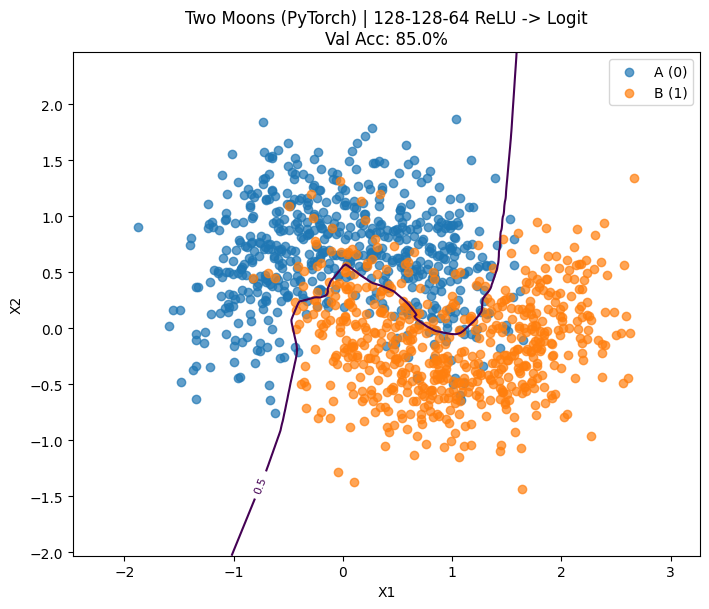

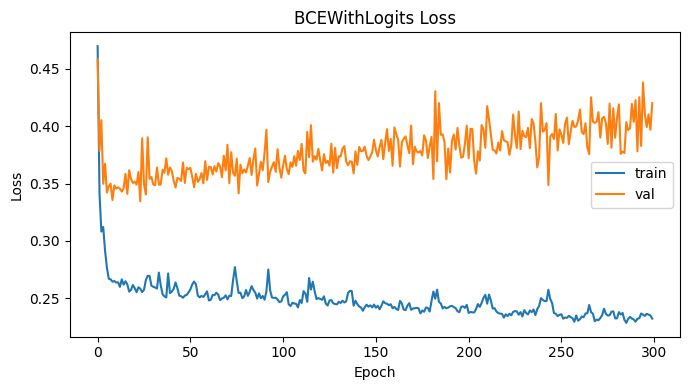

'\n# 3) Accuracy curves\nfig3 = plt.figure(figsize=(7, 4))\nplt.plot(train_accs, label="train")\nplt.plot(val_accs, label="val")\nplt.title("Accuracy")\nplt.xlabel("Epoch"); plt.ylabel("Accuracy")\nplt.legend()\nplt.tight_layout()\nplt.show()\n'

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===========================================================
 Two Moons — PyTorch Training Script (Non-GUI)
===========================================================

A streamlined PyTorch implementation of a multilayer 
perceptron (MLP) classifier for the classic “Two Moons” 
dataset. This version focuses on reproducible model 
training, validation, and visualization of decision 
boundaries without a graphical interface.

It uses PyTorch’s automatic differentiation, 
BCEWithLogitsLoss, and Adam optimizer to demonstrate 
binary classification with a simple yet effective 
feedforward neural network. The script provides training/
validation curves, accuracy tracking, and decision 
boundary plots for intuitive interpretation of learning 
behavior.

-----------------------------------------------------------
 Author:  Burak Demirel
 Title:   MRI Clinical Scientist
 Company: Philips Healthcare
 Contact: burak.demirel@philips.com
-----------------------------------------------------------

Run with:
    python two_moons_pytorch_train.py

Requirements:
    - numpy
    - matplotlib
    - torch

Tested on:
    Python 3.9+, Windows/Linux/macOS

-----------------------------------------------------------
"""


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt

# ---------------------------
# Config
# ---------------------------
SEED = 42
N_SAMPLES = 1200
NOISE = 0.35
VAL_FRACTION = 0.2
BATCH_SIZE = 128
EPOCHS = 300
LR = 1e-2
WEIGHT_DECAY = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)

# ---------------------------
# Data
# ---------------------------
def make_moons(n=1200, noise=0.35):
    n2 = n // 2
    t = np.linspace(0, np.pi, n2)
    x1 = np.c_[np.cos(t), np.sin(t)]
    x2 = np.c_[1 - np.cos(t), 1 - np.sin(t)] + np.array([0.0, -0.5])
    X = np.vstack([x1, x2])
    X += noise * np.random.randn(*X.shape)
    y = np.hstack([np.zeros(n2), np.ones(n2)])
    return X.astype(np.float32), y.astype(np.float32)

def standardize_train_only(X_train, X_full):
    mu = X_train.mean(axis=0, keepdims=True)
    sd = X_train.std(axis=0, keepdims=True) + 1e-8
    X_full_std = (X_full - mu) / sd
    return X_full_std.astype(np.float32), mu.squeeze(0), sd.squeeze(0)

X, y = make_moons(N_SAMPLES, NOISE)

# Split indices first, then standardize using TRAIN ONLY stats
num_val = int(VAL_FRACTION * len(X))
num_train = len(X) - num_val
# Build a TensorDataset first to use torch random_split for reproducibility
full_ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
train_ds, val_ds = random_split(full_ds, [num_train, num_val], generator=torch.Generator().manual_seed(SEED))

# Extract numpy arrays back for standardization (train-only stats)
X_train_np = train_ds[:][0].numpy()
X_full_std, mu, sd = standardize_train_only(X_train_np, X)

# Rebuild datasets with standardized features
X_std_t = torch.from_numpy(X_full_std)
y_t = torch.from_numpy(y).unsqueeze(1)  # shape (N, 1)

full_std_ds = TensorDataset(X_std_t, y_t)
# Use same splits lengths; fresh split with same seed to mirror indices
train_ds, val_ds = random_split(full_std_ds, [num_train, num_val], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# ---------------------------
# Model
# ---------------------------
class MLP(nn.Module):
    def __init__(self, in_dim=2, h1=128, h2=128, h3=64):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, 1)  # single logit
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        z = self.out(x)  # logits
        return z

model = MLP().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.BCEWithLogitsLoss()

# ---------------------------
# Train / Validate
# ---------------------------
def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        if train:
            optimizer.zero_grad()
        logits = model(xb)                # (B, 1)
        loss = criterion(logits, yb)      # BCEWithLogits on raw logits
        if train:
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            total_correct += (preds == yb).sum().item()
            total_count += yb.numel()
        total_loss += loss.item() * yb.size(0)
    avg_loss = total_loss / total_count
    acc = total_correct / total_count
    return avg_loss, acc

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(1, EPOCHS + 1):
    tl, ta = run_epoch(train_loader, train=True)
    vl, va = run_epoch(val_loader, train=False)
    train_losses.append(tl); val_losses.append(vl)
    train_accs.append(ta);  val_accs.append(va)
    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}: train_loss={tl:.4f} val_loss={vl:.4f} train_acc={ta*100:.1f}% val_acc={va*100:.1f}%")

# ---------------------------
# Decision boundary (use full grid, standardized with train stats)
# ---------------------------
x_min, x_max = X[:, 0].min() - 0.6, X[:, 0].max() + 0.6
y_min, y_max = X[:, 1].min() - 0.6, X[:, 1].max() + 0.6
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
grid_s = (grid - mu) / sd
grid_s_t = torch.from_numpy(grid_s).to(DEVICE)
with torch.no_grad():
    logits_g = model(grid_s_t).cpu().numpy().reshape(xx.shape)
    Pg = 1.0 / (1.0 + np.exp(-logits_g))

# ---------------------------
# Plots
# ---------------------------
# 1) Decision boundary + data
fig1 = plt.figure(figsize=(7.2, 6.2))
mask = y > 0.5
plt.scatter(X[~mask, 0], X[~mask, 1], alpha=0.7, label="A (0)")
plt.scatter(X[mask, 0], X[mask, 1], alpha=0.7, label="B (1)")
cs = plt.contour(xx, yy, Pg, levels=[0.5])
plt.clabel(cs, inline=True, fontsize=8)

# Compute final val accuracy for title
final_val_acc = val_accs[-1] if len(val_accs) else 0.0
plt.title(f"Two Moons (PyTorch) | 128-128-64 ReLU -> Logit\nVal Acc: {final_val_acc*100:.1f}%")
plt.legend(); plt.xlabel("X1"); plt.ylabel("X2")
plt.tight_layout()
plt.show()

# 2) Loss curves
fig2 = plt.figure(figsize=(7, 4))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.title("BCEWithLogits Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

'''
# 3) Accuracy curves
fig3 = plt.figure(figsize=(7, 4))
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="val")
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()
'''